In [ ]:
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
import chess
import pandas as pd
import numpy as np
import utils.chess_utils as chess_utils
import matplotlib.pyplot as plt
import seaborn as sns
from utils.pikeBot_chess_utils import Pikebot, PikeBotModelWrapper
from evaluation_utils import set_engine_history, get_probabilities

In [2]:
import zstandard as zstd

input_file = 'data/lichess_db_puzzle.csv.zst'
output_file = 'data/lichess_db_puzzle.csv'

In [3]:
with open(input_file, 'rb') as compressed_file:
    with open(output_file, 'wb') as decompressed_file:
        dctx = zstd.ZstdDecompressor()
        dctx.copy_stream(compressed_file, decompressed_file)

print("File decompressed successfully!")

File decompressed successfully!


In [32]:
df = pd.read_csv(output_file)
df = df[:1000]
df.head(10)

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - ...,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1996,75,95,6860,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,NaN
1,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - ...,d3d6 f8d8 d6d8 f6d8,1574,73,96,28960,advantage endgame short,https://lichess.org/F8M8OS71#53,NaN
2,0008Q,8/4R3/1p2P3/p4r2/P6p/1P3Pk1/4K3/8 w - - 1 64,e7f7 f5e5 e2f1 e5e6,1317,75,90,650,advantage endgame rookEndgame short,https://lichess.org/MQSyb3KW#127,NaN
3,0009B,r2qr1k1/b1p2ppp/pp4n1/P1P1p3/4P1n1/B2P2Pb/3NBP...,b6c5 e2g4 h3g4 d1g4,1099,74,87,571,advantage middlegame short,https://lichess.org/4MWQCxQ6/black#32,Kings_Pawn_Game Kings_Pawn_Game_Leonardis_Vari...
4,000VW,r4r2/1p3pkp/p5p1/3R1N1Q/3P4/8/P1q2P2/3R2K1 b -...,g6f5 d5c5 c2e4 h5g5 g7h8 g5f6,2764,88,94,68,crushing endgame long,https://lichess.org/e9AY2m5j/black#50,NaN
5,000Vc,8/8/4k1p1/2KpP2p/5PP1/8/8/8 w - - 0 53,g4h5 g6h5 f4f5 e6e5 f5f6 e5f6,1575,80,75,97,crushing endgame long pawnEndgame,https://lichess.org/l6AejDMO#105,NaN
6,000Zo,4r3/1k6/pp3r2/1b2P2p/3R1p2/P1R2P2/1P4PP/6K1 w ...,e5f6 e8e1 g1f2 e1f1,1353,75,86,622,endgame mate mateIn2 short,https://lichess.org/n8Ff742v#69,NaN
7,000aY,r4rk1/pp3ppp/2n1b3/q1pp2B1/8/P1Q2NP1/1PP1PP1P/...,g5e7 a5c3 b2c3 c6e7,1449,79,74,506,advantage master middlegame short,https://lichess.org/iihZGl6t#29,Benoni_Defense Benoni_Defense_Benoni-Indian_De...
8,000hf,r1bqk2r/pp1nbNp1/2p1p2p/8/2BP4/1PN3P1/P3QP1P/3...,e8f7 e2e6 f7f8 e6f7,1501,76,90,523,mate mateIn2 middlegame short,https://lichess.org/71ygsFeE/black#38,Horwitz_Defense Horwitz_Defense_Other_variations
9,000lC,3r3r/pQNk1ppp/1qnb1n2/1B6/8/8/PPP3PP/3R1R1K w ...,d1d6 d7d6 b7b6 a7b6,1324,75,96,2501,advantage hangingPiece middlegame short,https://lichess.org/vaqz2bx6#37,NaN


In [33]:
df["Board"] = df["FEN"].apply(chess.Board)
df.head(2)

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags,Board
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - ...,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1996,75,95,6860,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,NaN,r . . . . . . k\np p . . r . . p\n. . . . R p ...
1,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - ...,d3d6 f8d8 d6d8 f6d8,1574,73,96,28960,advantage endgame short,https://lichess.org/F8M8OS71#53,NaN,. . . . . r k .\n. p . . . p p p\np q . . . b ...


In [6]:
stockfish_path = "D:/Program Files/Stockfish/stockfish/stockfish-windows-x86-64-avx2.exe"
model_path = "../Models/PikeBot_Models/small_500k/PikeBotSmall500k.pth"
preprocessing_parameters_path = "../model_loading_data/preprocessing_parameters.json"


model = PikeBotModelWrapper(model_path, preprocessing_parameters_path)
engine = Pikebot( model=model, 
                        aggregate=chess_utils.mean_aggr,
                        stockfish_path=stockfish_path,
                        color=chess.WHITE,
                        opponents_elo = 800
                        )

In [ ]:
elos = [800, 1100, 1400, 1700, 2000, 2300, 2600]

def test_games(index, color):    
    games = df[index]
    engine.color = color
    predictions = list()
    #iterate over games
    all_moves_predictions = [[] for _ in range(len(elos))]
    for game in games.itertuples():
        board: chess.Board = game.Board.copy()
        board_history = [board]
        set_engine_history(engine, board_history)
        #iterate over moves in position  
        for i, move in enumerate(game.Moves.split()):
            #evaluate only moves of one side 
            if i % 2 == 1:
                position_predictions = list()
                for i, elo in enumerate(elos):
                    choice_probs = get_probabilities(engine, elo, board, model)
                    all_moves_predictions[i].extend(choice_probs)

                    legal_moves_uci = [move.uci() for move in board.legal_moves]
                    move_index = legal_moves_uci.index(move)
                    probability_order = np.argsort(choice_probs)
                    move_position = np.where(probability_order==move_index)

                    position_predictions.append(choice_probs[move_index])
                    position_predictions.append(move_position[0][0])
                predictions.append([game.Rating]+ position_predictions)

            board.push_uci(move)
            score = engine.get_board_score(board)
            engine.move_history.append(board.copy())
            engine.evaluation_history.append(score)
    return predictions, all_moves_predictions


In [34]:
white_index = df.Board.apply(lambda x: x.turn) 
black_index = df.Board.apply(lambda x: not x.turn) 

result_black, all_predictions_black = test_games(white_index, chess.BLACK)
result_white, all_predictions_white = test_games(black_index, chess.WHITE)

In [35]:
column_names = ["Rating"]
for elo in elos:
    column_names.append(f"{elo}_prediction")
    column_names.append(f"{elo}_position")
white_df = pd.DataFrame(result_white, columns=column_names)
black_df = pd.DataFrame(result_black, columns=column_names)
prediction_df = pd.concat([white_df, black_df])
prediction_df.head()

,Rating,800_prediction,800_position,1100_prediction,1100_position,1400_prediction,1400_position,1700_prediction,1700_position,2000_prediction,2000_position,2300_prediction,2300_position,2600_prediction,2600_position
0,1996,0.325004,8,0.315100,8,0.259340,3,0.268886,8,0.231447,7,0.238334,7,0.192483,6
1,1996,0.009621,0,0.006322,0,0.006572,0,0.004558,0,0.004052,0,0.003004,0,0.002542,0
2,1996,0.459157,0,0.384521,0,0.355989,0,0.258246,0,0.267894,0,0.185027,0,0.180694,0
3,1099,0.806464,16,0.799439,16,0.802356,16,0.788590,16,0.794255,16,0.788884,16,0.790976,16
4,1099,0.791410,23,0.790733,22,0.790515,22,0.791905,22,0.784713,23,0.794591,22,0.792433,22


In [36]:
column_names = list()
for elo in elos:
    column_names.append(f"{elo}_prediction")
all_predictions_df_white = pd.DataFrame(all_predictions_white).T
all_predictions_df_black = pd.DataFrame(all_predictions_black).T
all_predictions_df = pd.concat([
    all_predictions_df_white, all_predictions_df_black
])
all_predictions_df.columns = column_names
all_predictions_df.head()

,800_prediction,1100_prediction,1400_prediction,1700_prediction,2000_prediction,2300_prediction,2600_prediction
0,0.504650,0.512007,0.513607,0.512411,0.507125,0.519546,0.516107
1,0.633436,0.635452,0.630048,0.648025,0.650537,0.653630,0.651045
2,0.282602,0.304120,0.481767,0.232970,0.138752,0.216896,0.194630
3,0.788485,0.790817,0.794581,0.796358,0.798818,0.801896,0.803828
4,0.821459,0.826848,0.836033,0.837543,0.840686,0.842818,0.844350


In [37]:
prediction_df.to_csv("results/puzzle_prediction2.csv", index=False)
all_predictions_df.to_csv("results/puzzle_prediction3.csv", index=False)

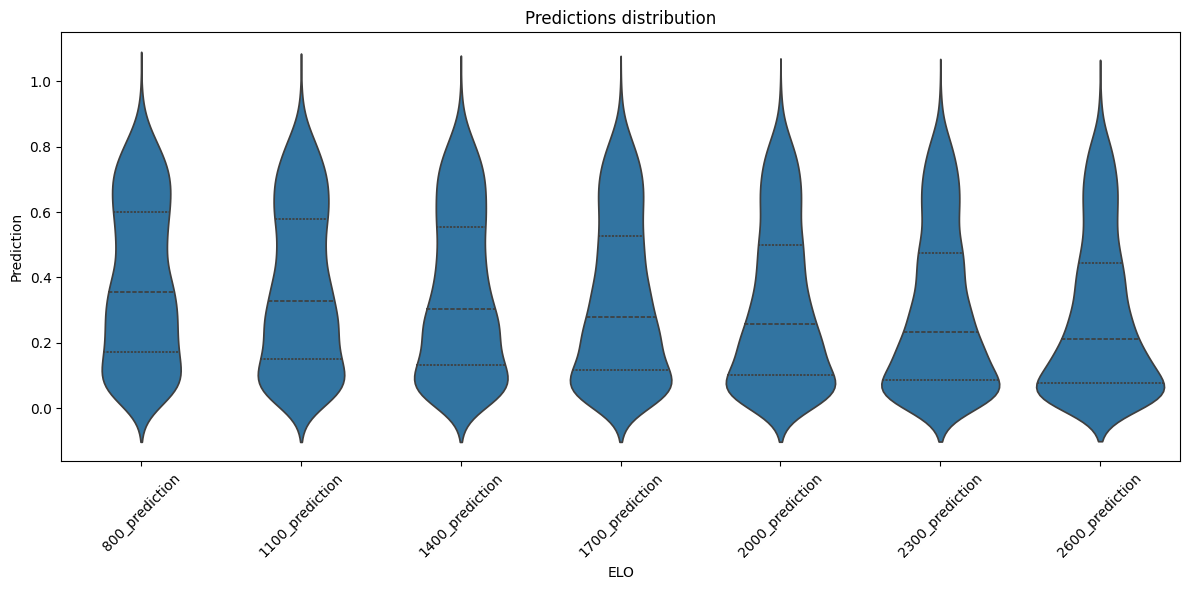

In [38]:
prediction_columns = [col for col in prediction_df.columns if col.endswith('_prediction')]

df_long = prediction_df.melt(value_vars=prediction_columns, 
                  var_name='ELO', 
                  value_name='Prediction')


# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_long, x='ELO', y='Prediction', inner='quartile')

# Improve plot aesthetics
plt.xticks(rotation=45)
plt.title("Predictions distribution")
plt.tight_layout()
plt.show()

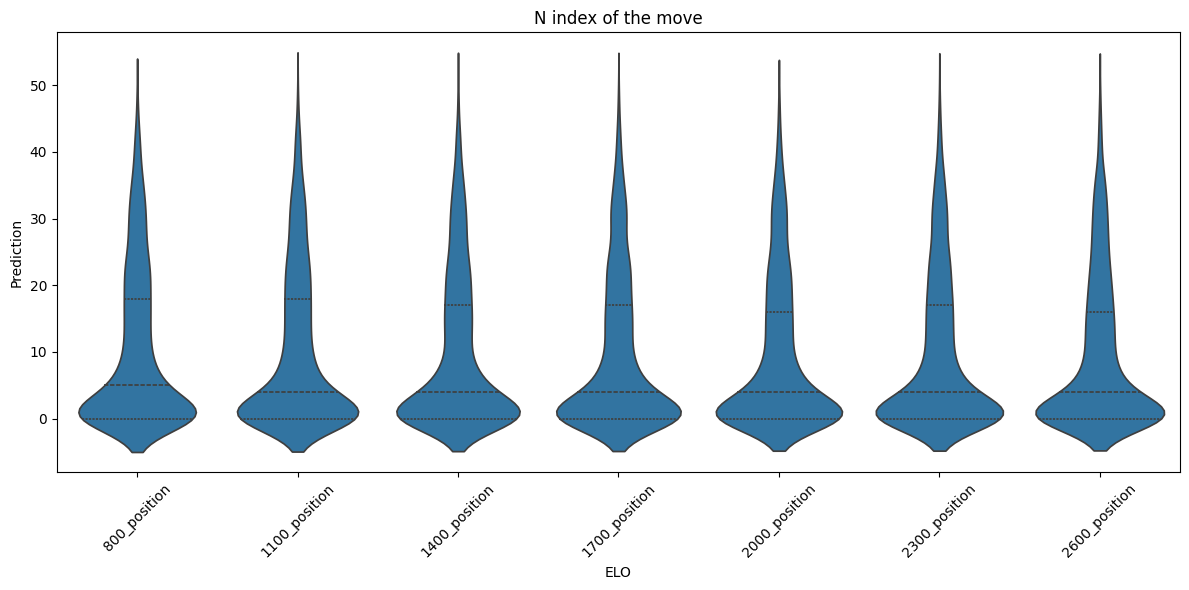

In [39]:
position_columns = [col for col in prediction_df.columns if col.endswith('_position')]

df_long = prediction_df.melt(value_vars=position_columns, 
                  var_name='ELO', 
                  value_name='Prediction')


# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_long, x='ELO', y='Prediction', inner='quartile')

# Improve plot aesthetics
plt.xticks(rotation=45)
plt.title("N index of the move")
plt.tight_layout()
plt.show()

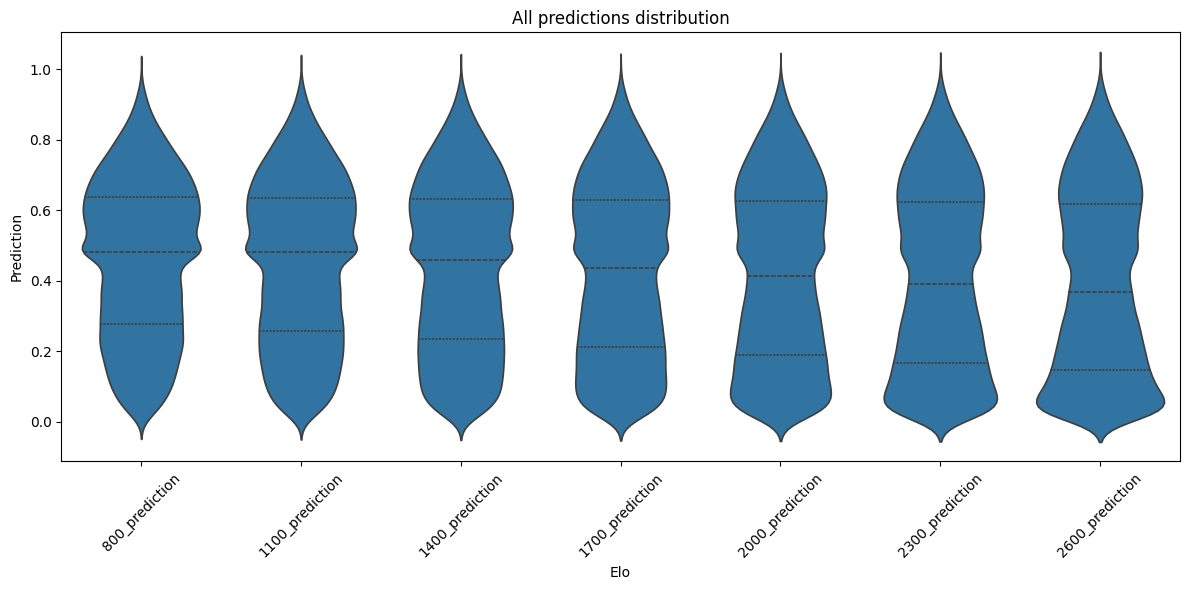

In [40]:
df_long = all_predictions_df.melt(
                  var_name='Elo', 
                  value_name='Prediction')

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_long, x='Elo', y='Prediction', inner='quartile')

# Improve plot aesthetics
plt.xticks(rotation=45)
plt.title("All predictions distribution")
plt.tight_layout()
plt.show()

In [41]:
from scipy.stats import pearsonr

flatten_predictions = prediction_df[prediction_columns].to_numpy()
no_samples = flatten_predictions.shape[0]
flatten_predictions = flatten_predictions.reshape(-1)

correlation, p_value = pearsonr(flatten_predictions, elos*no_samples)

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


Pearson correlation coefficient: -0.14074643785970997
P-value: 2.947079021832858e-71


In [42]:
flatten_positions = prediction_df[position_columns].to_numpy()
no_samples = flatten_positions.shape[0]
flatten_predictions = flatten_positions.reshape(-1)

correlation, p_value = pearsonr(flatten_predictions, elos*no_samples)

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: -0.025913920225121907
P-value: 0.001073646191104597


In [43]:
flatten_positions = all_predictions_df.to_numpy()
no_samples = flatten_positions.shape[0]
flatten_predictions = flatten_positions.reshape(-1)

correlation, p_value = pearsonr(flatten_predictions, elos*no_samples)

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: -0.10006161661614578
P-value: 0.0
